In [6]:
# Imports
import time
import math
import sys
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy
from PIL import Image
from scipy import ndimage
from utils import *
from model import cnn_model

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(2)

In [ ]:
# train_data_orig, train_labels_orig, eval_data_orig, eval_labels_orig, classes = load_dataset()
# classes = 6
# train_labels = np.squeeze(train_labels_orig)
# train_labels_old = train_labels
# train_labels = one_hot_label(classes, train_labels_old)
# eval_labels = np.squeeze(eval_labels_orig)
# eval_labels_old = eval_labels
# eval_labels = one_hot_label(classes, eval_labels_old)
# # Flatten the training and test images
# train_data = train_data_orig.reshape(train_data_orig.shape[0], -1).T
# eval_data = eval_data_orig.reshape(eval_data_orig.shape[0], -1).T
# # Normalize image vectors
# train_data = train_data/255.
# eval_data = eval_data/255.
# features = train_data.shape[0]
# print(train_data.shape)

In [2]:
# Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images # Returns np.array
classes = 10
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
train_labels = one_hot_label(classes, train_labels)
eval_data = mnist.test.images # Returns np.array
eval_labels_old = np.asarray(mnist.test.labels, dtype=np.int32)
eval_labels = one_hot_label(classes, eval_labels_old)
features = train_data.shape[0]

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# Input Layer
input_layer = train_data.reshape(55000,1,28,28)
eval_data = eval_data.reshape(10000,1,28,28)
#plt.imshow(input_layer[0,0])

(55000, 784)
(10000, 784)


## Plan
**input layer:** mx28x28x1

**conv layer1 + Relu:** mx28x28x32

**pool layer1:** mx14x14x32

**conv layer2 + Relu:** mx14x14x64

**pool layer2:** mx7x7x64

**flatten:** mx3136

**fc layer1:** mx1024

**output layer:** mx10

**softmax:** mx10

Cost after iteration 0, batch 0: 2.361211
Cost after iteration 0, batch 1: 2.313739
Cost after iteration 0, batch 2: 2.201079
Cost after iteration 0, batch 3: 2.090867
Cost after iteration 0: 2.090867
Cost after iteration 1, batch 0: 2.051872
Cost after iteration 1, batch 1: 1.912637
Cost after iteration 1, batch 2: 1.892555
Cost after iteration 1, batch 3: 1.867720
Cost after iteration 1: 1.867720
Cost after iteration 2, batch 0: 1.834600
Cost after iteration 2, batch 1: 1.708729
Cost after iteration 2, batch 2: 1.602908
Cost after iteration 2, batch 3: 1.647081
Cost after iteration 2: 1.647081


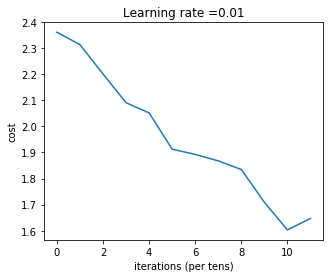

In [75]:
# training model
filter_dims = [(32,1,5,5),(64,32,5,5)]
layers_dims = [3136, 1024, classes] #  2-layer model
parameters, parameters_conv, grads, conv_grads = cnn_model(input_layer[0:256], train_labels[0:256], filter_dims, layers_dims, 
                                                           truncate = 0, batch_size = 64, learning_rate = 0.01, num_iterations = 3, print_cost = True)


Cost after iteration 0, batch 0: 0.874407
Cost after iteration 0, batch 1: 0.892292
Cost after iteration 0, batch 2: 0.965099
Cost after iteration 0, batch 3: 0.877747
Cost after iteration 0, batch 4: 0.828231
Cost after iteration 0, batch 5: 0.788614
Cost after iteration 0, batch 6: 0.817186
Cost after iteration 0, batch 7: 0.925907
Cost after iteration 0: 0.925907
Cost after iteration 1, batch 0: 0.890119
Cost after iteration 1, batch 1: 0.952875
Cost after iteration 1, batch 2: 1.049451
Cost after iteration 1, batch 3: 0.892852
Cost after iteration 1, batch 4: 0.798231
Cost after iteration 1, batch 5: 0.761457
Cost after iteration 1, batch 6: 0.795497
Cost after iteration 1, batch 7: 0.895016
Cost after iteration 1: 0.895016
Cost after iteration 2, batch 0: 0.871007
Cost after iteration 2, batch 1: 0.919327
Cost after iteration 2, batch 2: 0.994641
Cost after iteration 2, batch 3: 0.864421
Cost after iteration 2, batch 4: 0.794863
Cost after iteration 2, batch 5: 0.748471
Cost after

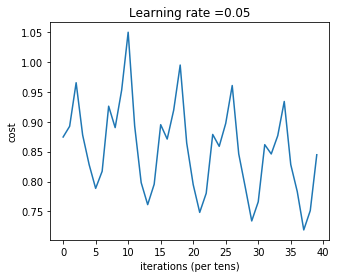

In [88]:
#further training on the same model 
parameters, parameters_conv, grads, conv_grads = cnn_model(input_layer[0:1024], train_labels[:,0:1024], layers_dims, filter_dims, 
                                                           truncate = 0, batch_size = 128, learning_rate = 0.05, num_iterations = 5, parameters = parameters, parameters_conv = parameters_conv, print_cost = True)


In [ ]:
train_labels.shape

In [13]:
#eval_cnn_model(input_layer[0:256], train_labels[:,0:256], parameters, parameters_conv)

eval_cnn_model(eval_data[0:256], eval_labels[:,0:256], parameters, parameters_conv)

ValueError: operands could not be broadcast together with shapes (64,) (1024,256) 

In [ ]:
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
image_num = 88
predict_cnn(eval_data[image_num:image_num+1],parameters, parameters_conv)
print("actual value: " + str(eval_labels_old[image_num]))
data = mnist.test.images[image_num].reshape(28,28)
plt.imshow(data)

In [ ]:
out = np.concatenate((parameters_conv['W1'].reshape(-1),parameters_conv['b1'].reshape(-1), 
                     parameters_conv['W3'].reshape(-1), parameters_conv['b3'].reshape(-1)))
mu = np.mean(out)
variance = np.var(out)
sigma = math.sqrt(variance)
x = np.linspace(mu - 4 * sigma , mu + 4 * sigma , 1000)
plt.plot(x,mlab.normpdf(x, mu, sigma))
plt.show()
print("one std is",sigma)

In [ ]:
out_m = np.concatenate((parameters_conv['W1'].reshape(-1),parameters_conv['b1'].reshape(-1), 
                     parameters_conv['W3'].reshape(-1), parameters_conv['b3'].reshape(-1)))
mu_m = np.mean(out_m)
variance_m = np.var(out_m)
sigma_m = math.sqrt(variance_m)
x_m = np.linspace(mu_m - 4 * sigma_m , mu_m + 4 * sigma_m , 1000)
plt.plot(y,mlab.normpdf(x_m, mu_m, sigma_m),'-', x, mlab.normpdf(x, mu, sigma), '--')
plt.show()
print("one std is",sigma_m)

In [ ]:
out = np.concatenate((conv_grads['dW1'].reshape(-1),conv_grads['db1'].reshape(-1), 
                     conv_grads['dW3'].reshape(-1), conv_grads['db3'].reshape(-1)))
mu = np.mean(out)
variance = np.var(out)
sigma = math.sqrt(variance)
x = np.linspace(mu - 4 * sigma , mu + 4 * sigma , 1000)
plt.plot(x,mlab.normpdf(x, mu, sigma))
plt.show()
print("one std is",sigma)

In [ ]:
out_m = np.concatenate((conv_grads['dW1'].reshape(-1),conv_grads['db1'].reshape(-1), 
                     conv_grads['dW3'].reshape(-1), conv_grads['db3'].reshape(-1)))
mu_m = np.mean(out_m)
variance_m = np.var(out_m)
sigma_m = math.sqrt(variance_m)
x_m = np.linspace(mu_m - 4 * sigma_m , mu_m + 4 * sigma_m , 1000)
plt.plot(x_m,mlab.normpdf(x_m, mu_m, sigma_m),'-', x, mlab.normpdf(x, mu, sigma), '--')
plt.show()
print("one std is",sigma_m)

In [ ]:
out_f = np.concatenate((conv_grads['dW1'].reshape(-1),conv_grads['db1'].reshape(-1), 
                     conv_grads['dW3'].reshape(-1), conv_grads['db3'].reshape(-1)))
mu_f = np.mean(out_f)
variance_f = np.var(out_f)
sigma_f = math.sqrt(variance_f)
x_f = np.linspace(mu_f - 4 * sigma_f , mu_f + 4 * sigma_f , 1000)
plt.plot(x_f,mlab.normpdf(x_f, mu_f, sigma_f),'-',x_m,mlab.normpdf(x_m, mu_m, sigma_m),'-.', x, mlab.normpdf(x, mu, sigma), '--')
plt.show()
print("one std is",sigma_f)

In [ ]:
t = np.arange(0., 5., 0.2)

# red dashes, blue squares and green triangles
plt.plot(t, t, 'r--', t, t**2, 'bs', t, t**3, 'g^', t, t**4, 'r-')
plt.show()

In [ ]:
out = np.concatenate((parameters_conv['W1'].reshape(-1),parameters_conv['W3'].reshape(-1),
                      parameters_conv['b1'].reshape(-1),parameters_conv['b3'].reshape(-1),
                      conv_grads['dW1'].reshape(-1), conv_grads['dW3'].reshape(-1),
                      conv_grads['db1'].reshape(-1),conv_grads['db3'].reshape(-1)))
out = out.reshape(-1,8)
np.savetxt("parameters.csv", out, delimiter=",")